In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
# https://www.mathworks.com/matlabcentral/answers/217746-implementing-a-sine-wave-with-linearly-changing-frequency
# For getting a periodic signal with constantly changing frequency

sr = 1000
f1 = 17
t1 = np.arange(0,2000)
f1 = np.linspace(f1-2,f1+2,3*len(t1))
p1 = np.cumsum(f1/sr)
f2 = 30
t2 = np.arange(0,2000)
f2 = np.hstack((np.linspace(f2+5,f2-5,int(1.5*len(t2))),\
                np.linspace(f2+3,f2+2,int(1.5*len(t2)))))
p2 = np.cumsum(f2/sr)

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-30,30,10)]]),\
                   time_mod = np.arange(500,2500)/2000)
net2, F2_true, _ = utils.make_network(f2, len(t2), \
                   np.hstack([i*np.ones(50) for i in [2,1]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,-10,10)]]),\
                   time_mod = np.hstack((utils.create_decay(1000,decay_len_end=200),\
                                         np.zeros((1000)))))
net3, F3_true, _ = utils.make_network(f2, len(t2), \
                   np.hstack([i*np.ones(50) for i in [2,1]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,-10,10)]]),\
                   time_mod = np.hstack((np.zeros((1000)),\
                                         utils.create_decay(1000,decay_len_start=200))))
x = np.zeros((100,2000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t2] += net3
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

Text(0, 0.5, 'Channel')

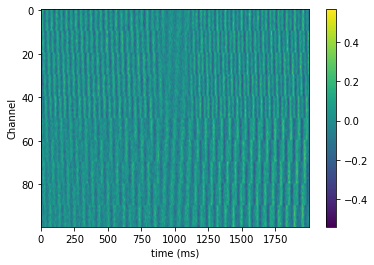

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [4]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.95, sim_thresh_freq=1, sim_thresh_phi_phase=10, \
                    opt_win=200, opt_stride=50, grad_alpha=0.07)
model.fit_opt(x, t, sr)

In [5]:
model.fit_reduction(x, len(t), sr)

Text(0, 0.5, 'Cosine Distance')

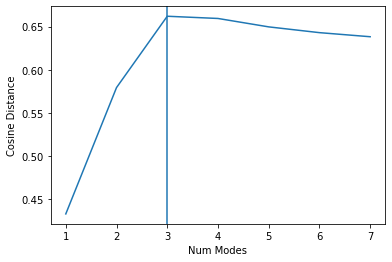

In [6]:
plt.plot(model.num_modes_, model.errors_)
plt.axvline(3)
plt.xlabel('Num Modes')
plt.ylabel('Cosine Distance')

In [7]:
model.fit_f(x, len(t), sr, 3)

Text(0, 0.5, 'f(t)')

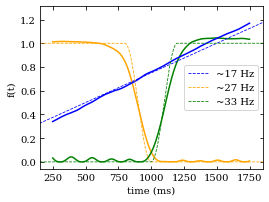

In [8]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

colors = ['orange', 'green', 'blue', 'green', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,250:-250]):
    ax.plot(np.arange(250,1750), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label='~17 Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label='~27 Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F3_true, axis=0), color=colors[1], label='~33 Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(150,1850)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')

In [9]:
freq_hat, phi_hat = model.get_freq_and_phi(len(t), sr)

Text(0, 0.5, 'freq (Hz)')

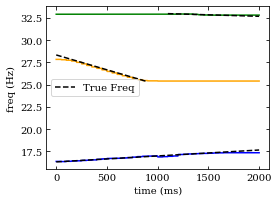

In [10]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.plot(freq_hat[0], color=colors[0])
ax.plot(freq_hat[1], color=colors[1])
ax.plot(freq_hat[2], color=colors[2])

ax.plot(np.arange(0,900), f2[2000:2900], color='black', linestyle='dashed', label='True Freq')
ax.plot(np.arange(1100,2000), f2[3100:4000], color='black', linestyle='dashed')
ax.plot(np.arange(2000), f1[2000:4000], color='black', linestyle='dashed')

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')

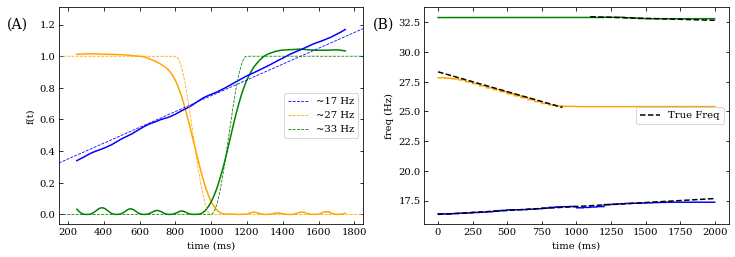

In [16]:
#Plot Figure

plt.rc('font', family='serif')
fig = plt.figure(figsize=(12,4))

#f(t)
ax = fig.add_subplot(121)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
colors = ['orange', 'green', 'blue', 'green', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,250:-250]):
    ax.plot(np.arange(250,1750), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label='~17 Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label='~27 Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F3_true, axis=0), color=colors[1], label='~33 Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(150,1850)
ax.set_xlabel('time (ms)')
ax.set_ylabel('f(t)')
ax.text(-0.17, 0.95, '(A)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

#freq
ax = fig.add_subplot(122)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)
ax.plot(freq_hat[0], color=colors[0])
ax.plot(freq_hat[1], color=colors[1])
ax.plot(freq_hat[2], color=colors[2])

ax.plot(np.arange(0,900), f2[2000:2900], color='black', linestyle='dashed', label='True Freq')
ax.plot(np.arange(1100,2000), f2[3100:4000], color='black', linestyle='dashed')
ax.plot(np.arange(2000), f1[2000:4000], color='black', linestyle='dashed')

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')
ax.text(-0.17, 0.95, '(B)', transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.savefig('figs/freq_drift.svg', bbox_inches='tight')

plt.show()

In [17]:
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

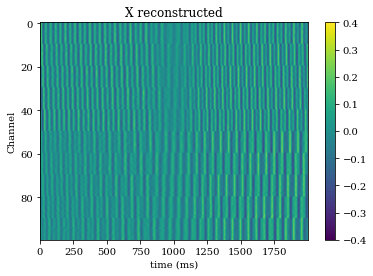

In [18]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

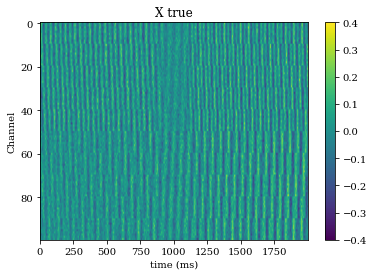

In [19]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')